In [1]:
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load the data. It has been re-ordered such that each replicate is one row.
df = pd.read_csv('biofilm_mod.csv')
le = LabelEncoder()
df['indices'] = le.fit_transform(df['isolate'])
df.head()

,experiment,isolate,ST,OD600,measurement,replicate,normalized_measurement,indices
0,1,1,4,0.461,0.317,1,0.687636,0
1,1,2,55,0.346,0.434,1,1.254335,7
2,1,3,55,0.356,0.917,1,2.575843,8
3,1,4,4,0.603,1.061,1,1.759536,9
4,1,5,330,0.444,3.701,1,8.335586,10


In [3]:
le.classes_

array(['1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6',
       '7', '8', '9', 'ATCC_29212'], dtype=object)

# Model

What's the best statistical formulation for this? As a start, let's begin with "each measurement is an independent measurement", and pool all of the data so that we don't lose information.

In [4]:
# Formulate BEST model.
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_one', lam=1/30) + 1
    
    fold = pm.Flat('fold', shape=max(df['indices']) + 1)
    
    var = pm.HalfCauchy('var', beta=1, shape=max(df['indices']) + 1)
    
    mu = fold[df['indices']]
    sd = var[df['indices']]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, observed=df['normalized_measurement'])

Applied log-transform to nu_minus_one and added transformed nu_minus_one_log_ to model.
Applied log-transform to var and added transformed var_log_ to model.


In [5]:
# Estimate posterior distribution using ADVI (fast)
with best:
    params = pm.variational.advi(n=100000)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -676.57
Iteration 10000 [10%]: Average ELBO = -222.03
Iteration 20000 [20%]: Average ELBO = -87.53
Iteration 30000 [30%]: Average ELBO = -64.32
Iteration 40000 [40%]: Average ELBO = -59.56
Iteration 50000 [50%]: Average ELBO = -59.12
Iteration 60000 [60%]: Average ELBO = -59.06
Iteration 70000 [70%]: Average ELBO = -59.15
Iteration 80000 [80%]: Average ELBO = -59.07
Iteration 90000 [90%]: Average ELBO = -59.06
Finished [100%]: Average ELBO = -59.07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11554e710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115974860>]], dtype=object)

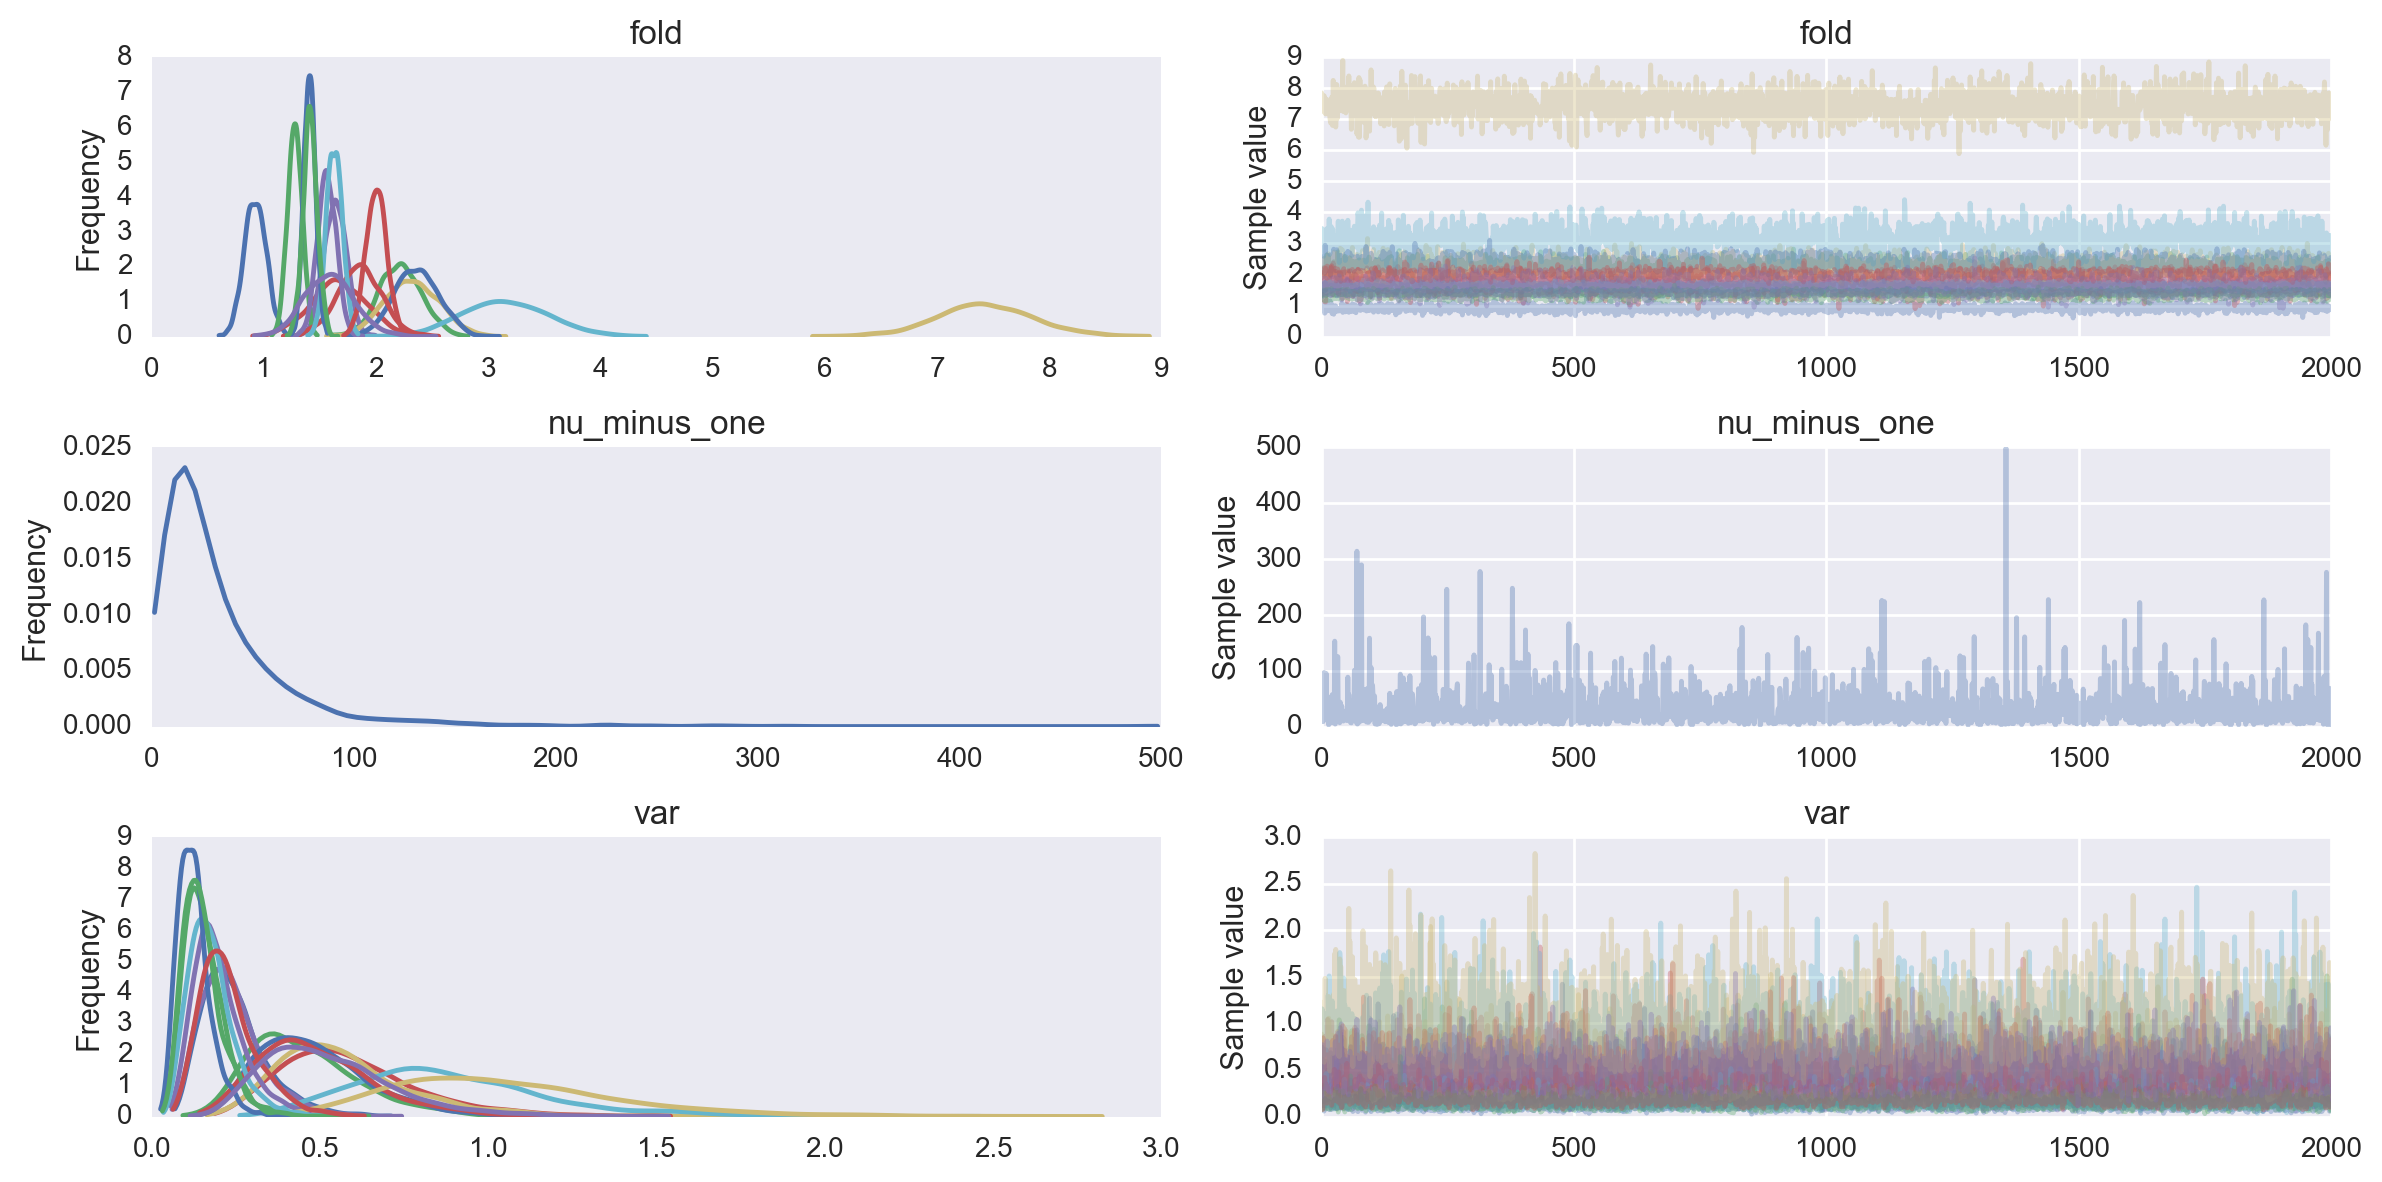

In [6]:
# Diagnostic plots, just to make sure things are okay.
pm.traceplot(trace)

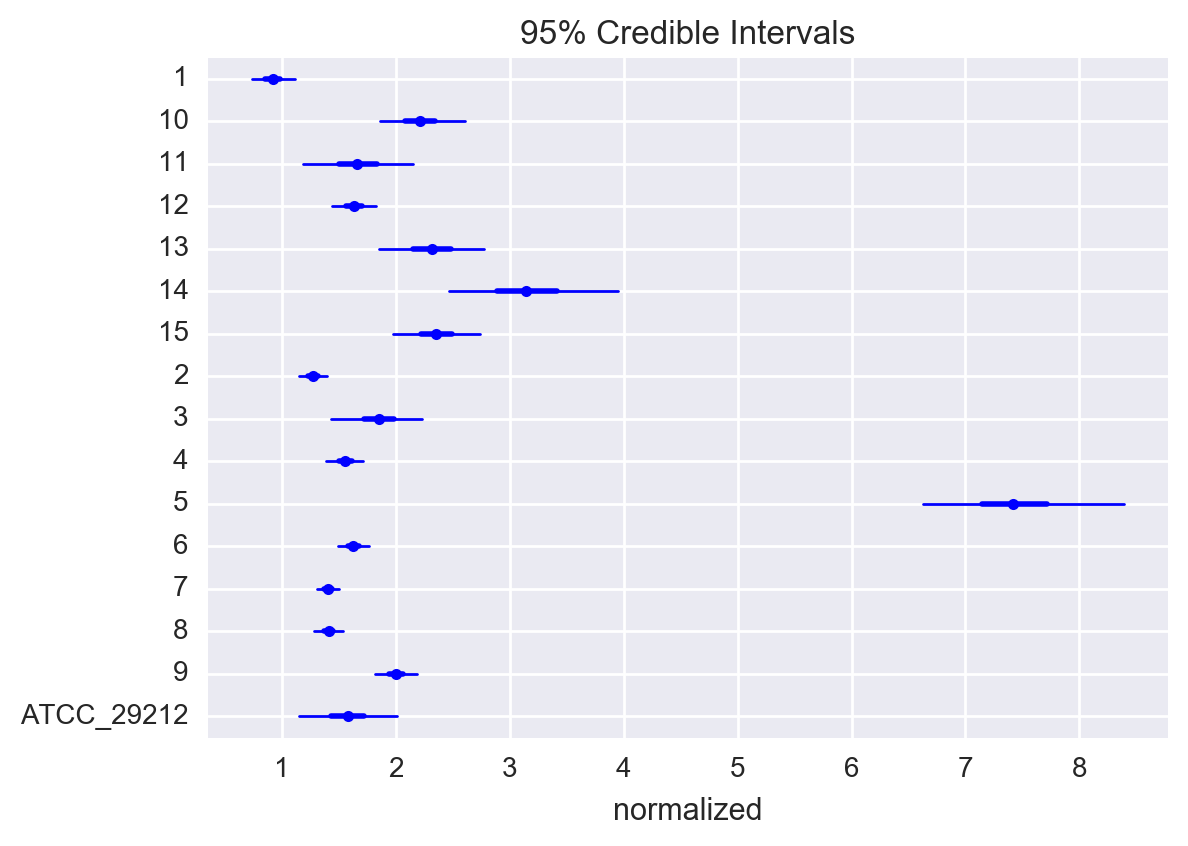

In [7]:
# Diagnostic plot, just to make sure things are okay.
pm.forestplot(trace, varnames=['fold'], ylabels=le.classes_, xtitle='normalized')

From the posterior distributions (as given by the `trace` object), we can grab out the 95% highest posterior density and IQR (25th-75th percentile).

In [8]:
# Get out 95% HPD and IQR from trace.
hpd_low, iqr_low, median, iqr_high, hpd_high = np.percentile(trace['fold'], [2.5, 25, 50, 75, 97.5], axis=0)
hpd_upper = hpd_high - median
hpd_lower = median - hpd_low

iqr_upper = iqr_high - median
iqr_lower = median - iqr_low

We can observe whether there are batch effects or not by looking at the beeswarm plots.

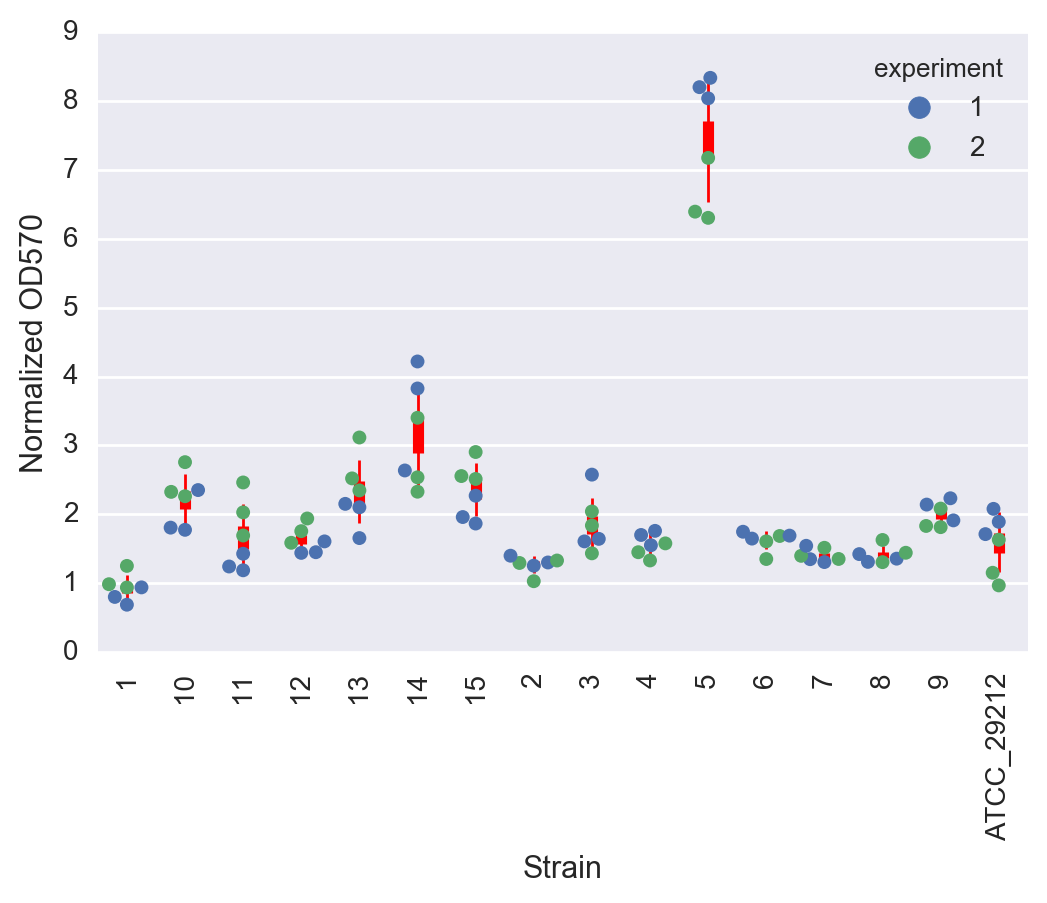

In [10]:
# Plot bee swarm plot + posterior distribution densities.
sns.swarmplot(data=df, x='indices', y='normalized_measurement', hue='experiment')
plt.errorbar(x=range(len(le.classes_)), y=median, yerr=[hpd_lower, hpd_upper], ls='none', color='red', elinewidth=1, label='95% HPD')
plt.errorbar(x=range(len(le.classes_)), y=median, yerr=[iqr_lower, iqr_upper], ls='none', color='red', elinewidth=4, label='IQR')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=90)
plt.xlabel('Strain')
plt.ylabel('Normalized OD570')
plt.show()
plt.savefig('measurement.pdf')

In general, it is difficult to tell whether experiment 2 (green dots) had an upward signal or downward signal. There are batch effects within a single strain, in that some of the green dots show clear separation from the blue dots, but across strains, the direction cannot be easily determined, indicating that there's no systematic bias between experiments.

Taken together, I would believe that the data can be safely pooled together. 